In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns

In [2]:
# Loading the dataset
data = pd.read_csv("./project_eda.csv")
data.info

<bound method DataFrame.info of                                                Indicator              Group  \
0      Took Prescription Medication for Mental Health...  National Estimate   
1      Took Prescription Medication for Mental Health...             By Age   
2      Took Prescription Medication for Mental Health...             By Age   
3      Took Prescription Medication for Mental Health...             By Age   
4      Took Prescription Medication for Mental Health...             By Age   
...                                                  ...                ...   
10399  Needed Counseling or Therapy But Did Not Get I...           By State   
10400  Needed Counseling or Therapy But Did Not Get I...           By State   
10401  Needed Counseling or Therapy But Did Not Get I...           By State   
10402  Needed Counseling or Therapy But Did Not Get I...           By State   
10403  Needed Counseling or Therapy But Did Not Get I...           By State   

               State       Subgroup Phase  Time Period      Time Period Label  \
0      United States  United States     2           13  Aug 19 - Aug 31, 2020   
1      United States  18 - 29 years     2           13  Aug 19 - Aug 31, 2020   
2      United States  30 - 39 years     2           13  Aug 19 - Aug 31, 2020   
3      United States  40 - 49 years     2           13  Aug 19 - Aug 31, 2020   
4      United States  50 - 59 years     2           13  Aug 19 - Aug 31, 2020   
...              ...            ...   ...          ...                    ...   
10399       Virginia       Virginia   3.4           45   Apr 27 - May 9, 2022   
10400     Washington     Washington   3.4           45   Apr 27 - May 9, 2022   
10401  West Virginia  West Virginia   3.4           45   Apr 27 - May 9, 2022   
10402      Wisconsin      Wisconsin   3.4           45   Apr 27 - May 9, 2022   
10403        Wyoming        Wyoming   3.4           45   Apr 27 - May 9, 2022   

       Value  LowCI  HighCI Quartile Range Usage_Category  
0       19.4   19.0    19.8       9.8-11.2         Medium  
1       18.7   17.2    20.3       9.8-11.2         Medium  
2       18.3   17.3    19.2       9.8-11.2         Medium  
3       20.4   19.5    21.3       9.8-11.2         Medium  
4       21.2   20.2    22.2       9.8-11.2         Medium  
...      ...    ...     ...            ...            ...  
10399   10.1    7.1    13.8       9.6-11.3            Low  
10400   14.8   12.5    17.4      13.0-20.8         Medium  
10401    9.8    6.6    13.8       9.6-11.3            Low  
10402   11.6    8.5    15.3      11.4-12.9            Low  
10403   11.5    8.6    15.1      11.4-12.9            Low  

[10404 rows x 12 columns]>

In [3]:
# Identify categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
print("Categorical Columns: ", cat_cols)

# Numerical variables:
num_cols = data.select_dtypes(include = ['float', 'int']).columns.to_list()
print("Numerical Columns: ",num_cols)

Categorical Columns:  ['Indicator', 'Group', 'State', 'Subgroup', 'Phase', 'Time Period Label', 'Quartile Range', 'Usage_Category']
Numerical Columns:  ['Time Period', 'Value', 'LowCI', 'HighCI']


In [4]:
X = data.drop(columns=['Usage_Category', 'Group', 'Subgroup'], axis=1)
y_usage_category = data['Usage_Category']
y_group = data['Group']
y_subgroup = data['Subgroup']

In [5]:
print(X.columns)

Index(['Indicator', 'State', 'Phase', 'Time Period', 'Time Period Label',
       'Value', 'LowCI', 'HighCI', 'Quartile Range'],
      dtype='object')


In [6]:
# Encode categorical features
X = pd.get_dummies(X, columns=['Indicator', 'State', 'Phase', 'Time Period Label', 'Quartile Range'])

# Encode targets
le_usage = LabelEncoder()
y_usage_category = le_usage.fit_transform(y_usage_category)

le_group = LabelEncoder()
y_by_group = le_group.fit_transform(y_group)

le_subgroup = LabelEncoder()
y_subgroup = le_subgroup.fit_transform(y_subgroup)

In [7]:
# Scaling numerical features
scaler = MinMaxScaler()
X[['Time Period', 'Value', 'LowCI', 'HighCI']] = scaler.fit_transform(X[['Time Period', 'Value', 'LowCI', 'HighCI']])

In [8]:
# Split data into training and testing
X_train, X_test, y_train_usage, y_test_usage = train_test_split(X, y_usage_category, test_size=0.2, random_state=42)
_, _, y_train_group, y_test_group = train_test_split(X, y_by_group, test_size=0.2, random_state=42)
_, _, y_train_subgroup, y_test_subgroup = train_test_split(X, y_subgroup, test_size=0.2, random_state=42)

In [9]:
# Shared input layer
input_layer = layers.Input(shape=(X_train.shape[1],))

# Shared feature extraction layers
shared = layers.Dense(64, activation='relu')(input_layer)
shared = layers.Dense(32, activation='relu')(shared)

# Usage Category Branch
usage_branch = layers.Dense(16, activation='relu')(shared)
usage_output = layers.Dense(len(le_usage.classes_), activation='softmax', name='usage_category')(usage_branch)

# By Group Branch
group_input = layers.Concatenate()([shared, usage_output])  # Add usage predictions as input
group_branch = layers.Dense(16, activation='relu')(group_input)
group_output = layers.Dense(len(le_group.classes_), activation='softmax', name='by_group')(group_branch)

# Subgroup Branch
subgroup_input = layers.Concatenate()([shared, usage_output, group_output])  # Add group predictions as input
subgroup_branch = layers.Dense(16, activation='relu')(subgroup_input)
subgroup_output = layers.Dense(len(le_subgroup.classes_), activation='softmax', name='subgroup')(subgroup_branch)

# Model
model = models.Model(inputs=input_layer, outputs=[usage_output, group_output, subgroup_output])

# Compile the model
model.compile(optimizer='adam',
              loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
              metrics=['accuracy','accuracy', 'accuracy'])


In [10]:
history = model.fit(
    X_train,
    [y_train_usage, y_train_group, y_train_subgroup],  # Multiple targets
    validation_data=(X_test, [y_test_usage, y_test_group, y_test_subgroup]),
    epochs=50,
    batch_size=32
)


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - by_group_accuracy: 0.6216 - by_group_loss: 1.5452 - loss: 6.7002 - subgroup_accuracy: 0.0200 - subgroup_loss: 4.3141 - usage_category_accuracy: 0.6043 - usage_category_loss: 0.8408 - val_by_group_accuracy: 0.7448 - val_by_group_loss: 0.7199 - val_loss: 4.6859 - val_subgroup_accuracy: 0.0764 - val_subgroup_loss: 3.6616 - val_usage_category_accuracy: 0.8818 - val_usage_category_loss: 0.2857
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - by_group_accuracy: 0.7461 - by_group_loss: 0.6789 - loss: 4.2709 - subgroup_accuracy: 0.1686 - subgroup_loss: 3.3625 - usage_category_accuracy: 0.9086 - usage_category_loss: 0.2296 - val_by_group_accuracy: 0.7501 - val_by_group_loss: 0.6826 - val_loss: 3.0391 - val_subgroup_accuracy: 0.6242 - val_subgroup_loss: 2.1387 - val_usage_category_accuracy: 0.9111 - val_usage_category_loss: 0.2015
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - by_group_accuracy: 0.7454 - by_group_loss: 0.6685 - 

In [32]:
# Evaluate on training set
train_results = model.evaluate(X_train, [y_train_usage, y_train_group, y_train_subgroup], verbose=0)
print(f"Training Loss: {train_results[0]:.4f}")
print(f"Training Accuracy (Usage Category): {train_results[6]:.2f}")
print(f"Training Accuracy (By Group): {train_results[4]:.2f}")
print(f"Training Accuracy (Subgroup): {train_results[5]:.2f}")

# Evaluate on validation set
val_results = model.evaluate(X_test, [y_test_usage, y_test_group, y_test_subgroup], verbose=0)
print(f"Validation Loss: {val_results[0]:.4f}")
print(f"Validation Accuracy (Usage Category): {val_results[6]:.2f}")
print(f"Validation Accuracy (By Group): {val_results[4]:.2f}")
print(f"Validation Accuracy (Subgroup): {val_results[5]:.2f}")

Training Loss: 1.0913
Training Accuracy (Usage Category): 0.99
Training Accuracy (By Group): 0.82
Training Accuracy (Subgroup): 0.78
Validation Loss: 1.4226
Validation Accuracy (Usage Category): 0.96
Validation Accuracy (By Group): 0.79
Validation Accuracy (Subgroup): 0.73


In [31]:
# Evaluate on test data
results = model.evaluate(X_test, [y_test_usage, y_test_group, y_test_subgroup])
#print(results)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy (Usage Category): {results[6]:.2f}")
print(f"Test Accuracy (By Group): {results[4]:.2f}")
print(f"Test Accuracy (Subgroup): {results[5]:.2f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - by_group_accuracy: 0.7961 - by_group_loss: 0.5038 - loss: 1.4296 - subgroup_accuracy: 0.7371 - subgroup_loss: 0.7565 - usage_category_accuracy: 0.9607 - usage_category_loss: 0.1687
[1.422621726989746, 0.15676996111869812, 0.5016199350357056, 0.7433525919914246, 0.7856799364089966, 0.7328207492828369, 0.9581931829452515]
Test Loss: 1.4226
Test Accuracy (Usage Category): 0.96
Test Accuracy (By Group): 0.79
Test Accuracy (Subgroup): 0.73


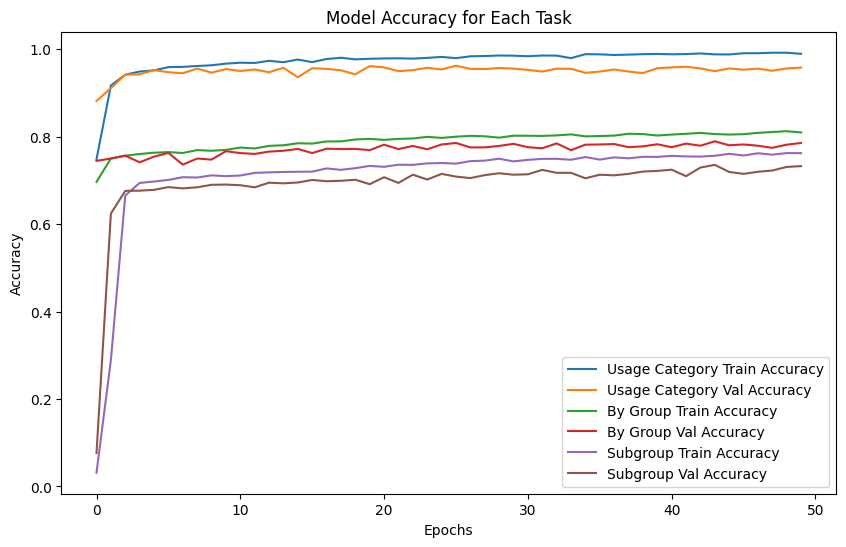

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy for each output
plt.figure(figsize=(10, 6))

# Usage Category Accuracy
plt.plot(history.history['usage_category_accuracy'], label='Usage Category Train Accuracy')
plt.plot(history.history['val_usage_category_accuracy'], label='Usage Category Val Accuracy')

# By Group Accuracy
plt.plot(history.history['by_group_accuracy'], label='By Group Train Accuracy')
plt.plot(history.history['val_by_group_accuracy'], label='By Group Val Accuracy')

# Subgroup Accuracy
plt.plot(history.history['subgroup_accuracy'], label='Subgroup Train Accuracy')
plt.plot(history.history['val_subgroup_accuracy'], label='Subgroup Val Accuracy')

plt.title('Model Accuracy for Each Task')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Predict on new data
predictions = model.predict(X_test)

# Convert predictions back to original labels
usage_preds = le_usage.inverse_transform(np.argmax(predictions[0], axis=1))
group_preds = le_group.inverse_transform(np.argmax(predictions[1], axis=1))
subgroup_preds = le_subgroup.inverse_transform(np.argmax(predictions[2], axis=1))

# Combine predictions for analysis
predictions_df = pd.DataFrame({
    'Usage_Category_Pred': usage_preds,
    'By_Group_Pred': group_preds,
    'Subgroup_Pred': subgroup_preds,
    'Usage_Category_True': le_usage.inverse_transform(y_test_usage),
    'By_Group_True': le_group.inverse_transform(y_test_group),
    'Subgroup_True': le_subgroup.inverse_transform(y_test_subgroup)
})

print(predictions_df.head())

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Usage_Category_Pred                                  By_Group_Pred  \
0                 Low                                   By Education   
1                High                     By Race/Hispanic ethnicity   
2                High  By Presence of Symptoms of Anxiety/Depression   
3              Medium                                         By Age   
4                 Low                                       By State   

                                       Subgroup_Pred Usage_Category_True  \
0                                 Hispanic or Latino                 Low   
1       Non-Hispanic, other races and multiple races                High   
2  Experienced symptoms of anxiety/depression in ...                High   
3                                      18 - 29 years              Medium   
4                                              Maine                 Low   

                                   By_Group_True  \
0                  

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Predict on test data
predictions = model.predict(X_test)

# Extract predictions for each target
usage_preds = np.argmax(predictions[0], axis=1)
group_preds = np.argmax(predictions[1], axis=1)
subgroup_preds = np.argmax(predictions[2], axis=1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


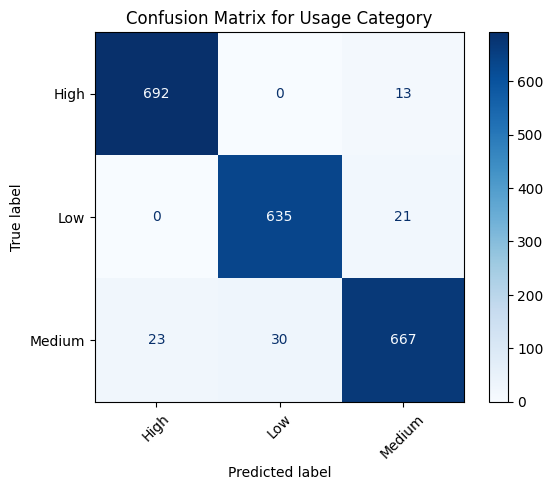

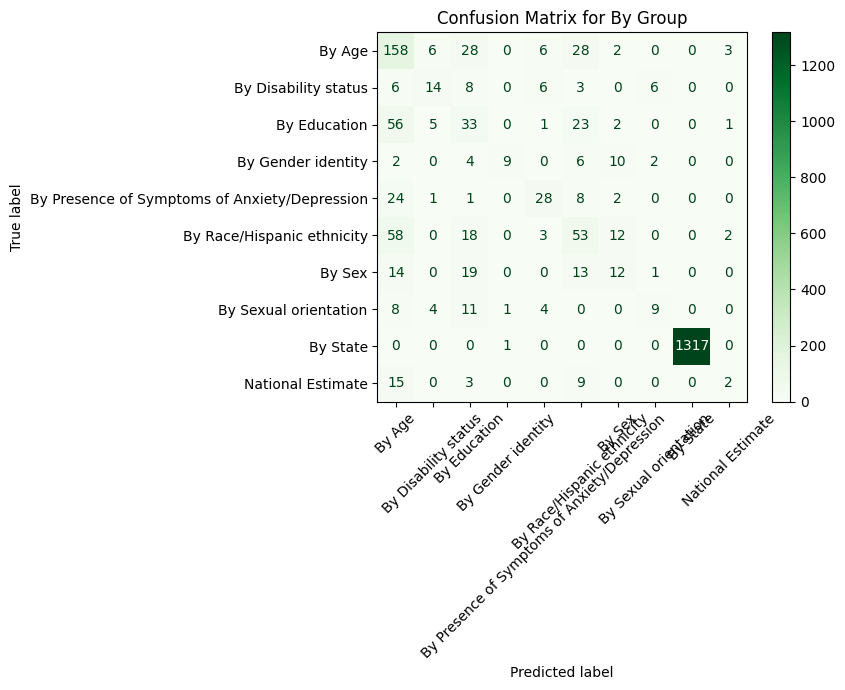

In [16]:
# Confusion Matrix for Usage Category
cm_usage = confusion_matrix(y_test_usage, usage_preds)
disp_usage = ConfusionMatrixDisplay(confusion_matrix=cm_usage, display_labels=le_usage.classes_)
disp_usage.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Usage Category")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

# Confusion Matrix for By Group
cm_group = confusion_matrix(y_test_group, group_preds)
disp_group = ConfusionMatrixDisplay(confusion_matrix=cm_group, display_labels=le_group.classes_)
disp_group.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for By Group")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()


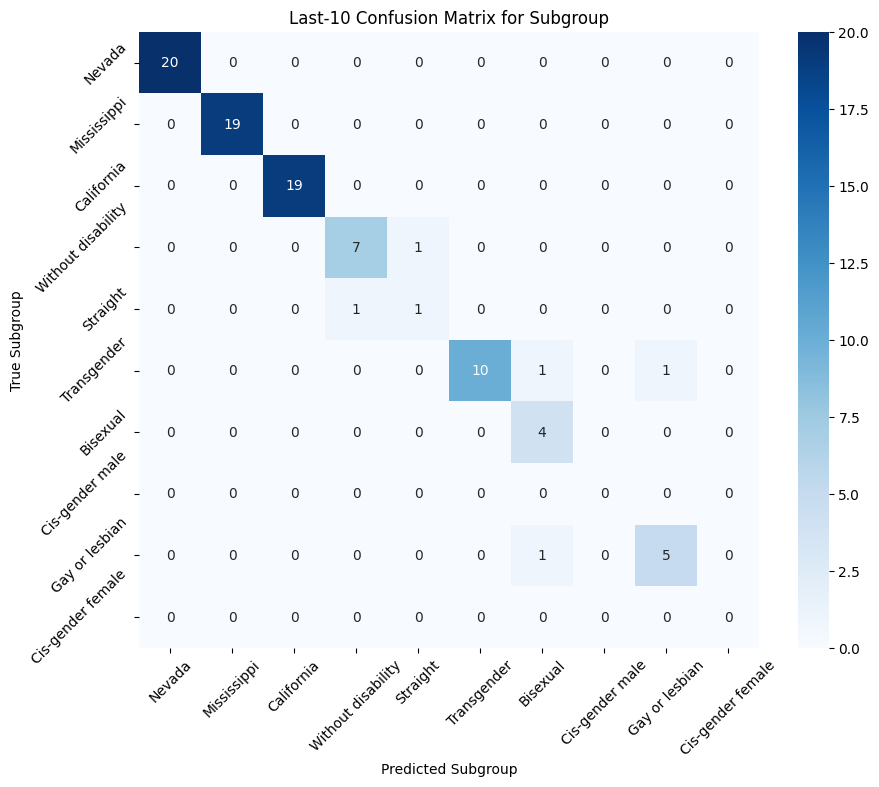

In [23]:
# Get the top-k most frequent subgroups from the true labels
top_k = 80
top_classes = pd.Series(y_test_subgroup).value_counts().index[70:top_k]  # Top-k most frequent encoded values

# Map encoded values to their class labels
top_class_labels = le_subgroup.inverse_transform(top_classes)

# Select only the top-k classes for the confusion matrix
cm_top = cm_df.loc[top_class_labels, top_class_labels]

# Plot using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues', xticklabels=top_class_labels, yticklabels=top_class_labels)
plt.title(f"Last-10 Confusion Matrix for Subgroup")
plt.xlabel("Predicted Subgroup")
plt.ylabel("True Subgroup")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
